# COLECT DATA

Import Library

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, SVMSMOTE, RandomOverSampler
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split

Importing Dataset

In [21]:
df = pd.read_csv("Dataset_Clean.csv")
df = df.drop(columns=['Unnamed: 0', 'UDI'])

In [22]:
num_data = ['Air temperature [K]','Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]','Temp_Delta', 'Power']
categorical = ['Type', 'Time/Part']

target1 = ['Failures']
target2 = ['TWF']

In [23]:
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,Temp_Delta,Power,Time/Part,Failures,Planned_Stop
0,M,298.1,308.6,1551,42.8,0,0,10.5,6951.590560,3,0,0
1,L,298.2,308.7,1408,46.3,3,0,10.5,6826.722724,2,0,0
2,L,298.1,308.5,1498,49.4,5,0,10.4,7749.387543,2,0,0
3,L,298.2,308.6,1433,39.5,7,0,10.4,5927.504659,2,0,0
4,L,298.2,308.7,1408,40.0,9,0,10.5,5897.816608,2,0,0


## **Imbalances**

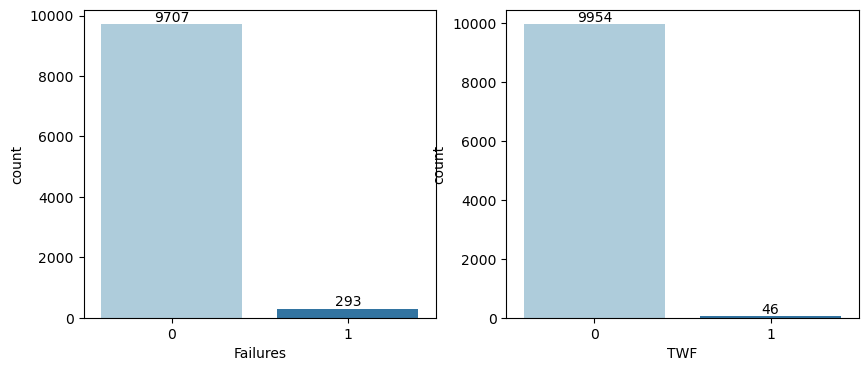

In [24]:
plt.figure(figsize=(10,4))
for idx, feature in enumerate(target1+target2):
  plt.subplot(1,2,idx+1)
  f = sns.countplot(data = df, x = feature, palette="Paired")
  f.bar_label(f.containers[0])

# BOOSTER TOGETHER

In [25]:
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
import pandas as pd

class BoostingFeatures:
    def __init__(self, df):
        self.df = df
        self.df_boosted = None

    def process_data(self):
        self.df_boosted = self.df.copy()

        # Boosting Failures
        for i in (('L', 2), ('M', 3), ('H', 5)):
            self.df_boosted['Type'] = self.df_boosted['Type'].replace(*i)

    def resample_data(self, target_feature):
        X = self.df_boosted.drop([target_feature], axis=1).values
        y = self.df_boosted[target_feature].values

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        smote_enn = SMOTEENN(sampling_strategy='auto', random_state=42)
        X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

        df_resampled = pd.DataFrame(X_train_resampled, columns=self.df_boosted.drop([target_feature], axis=1).columns)
        df_resampled[target_feature] = y_train_resampled

        return df_resampled

# Assuming you have 'df' defined
Boosting_Features = BoostingFeatures(df)
Boosting_Features.process_data()

# Boosting Failures
df_resampled_combined = Boosting_Features.resample_data('Failures')

# Boosting TWF
df_resampled_twf = Boosting_Features.resample_data('TWF')
df_resampled_combined['TWF'] = df_resampled_twf['TWF']  # Adding TWF to the combined DataFrame


In [29]:
df_resampled_twf

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Temp_Delta,Power,Time/Part,Failures,Planned_Stop,TWF
0,2.000000,298.200000,308.400000,1388.000000,53.800000,137.000000,10.200000,7819.884882,2.000000,0.0,0.0,0
1,3.000000,300.900000,310.800000,1599.000000,33.000000,7.000000,9.900000,5525.747318,3.000000,0.0,0.0,0
2,2.000000,301.400000,310.500000,1571.000000,33.900000,208.000000,9.100000,5577.049526,2.000000,0.0,0.0,0
3,2.000000,300.500000,310.500000,1373.000000,47.400000,56.000000,10.000000,6815.182607,2.000000,0.0,0.0,0
4,3.000000,297.300000,308.800000,1469.000000,44.100000,150.000000,11.500000,6784.049424,3.000000,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
15151,2.000000,299.019532,309.274496,1463.910412,40.990073,208.774818,10.254964,6281.841826,2.000000,0.0,0.0,1
15152,4.838007,298.132191,307.610591,1600.004162,36.164797,224.028039,9.478401,6059.010705,4.838007,0.0,0.0,1
15153,2.000000,299.311904,310.440713,2022.545594,21.254517,208.745251,11.128810,4448.497236,2.000000,0.0,0.0,1
15154,3.000000,300.296664,311.696664,1588.909136,32.040810,210.808374,11.400000,5319.841297,3.000000,0.0,0.0,1


In [26]:
df_resampled_combined.to_csv('Combined_Boosted.csv')

# BOOSTER EACH FEATURE

In [8]:
class Boosting_Failures:
    def __init__(self, df):
        self.df = df
        self.df1 = None 

    def process_data(self):
        self.df1 = self.df.drop(['TWF'], axis=1)
        for i in (('L', 0), ('M', 1), ('H', 2)):
            self.df1['Type'] = self.df1['Type'].replace(*i)

    def resample_data(self):
        X = self.df1.drop(['Failures'], axis=1).values
        y_failures = self.df1['Failures'].values

        X_train, X_test, y_train, y_test = train_test_split(X, y_failures, test_size=0.2, random_state=42)

        smote_enn = SMOTEENN(sampling_strategy='auto', random_state=42)

        X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

        df_resampled_1 = pd.DataFrame(X_train_resampled, columns=self.df1.drop(['Failures'], axis=1).columns)
        df_resampled_1['Failures'] = y_train_resampled

        return df_resampled_1
    
Boosting_Failures = Boosting_Failures(df)
Boosting_Failures.process_data()
df_resampled_1 = Boosting_Failures.resample_data()

In [9]:
df_resampled_1.describe()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Temp_Delta,Power,Time/Part,Planned_Stop,Failures
count,14269.000000,14269.000000,14269.000000,14269.000000,14269.000000,14269.000000,14269.000000,14269.000000,14269.000000,14269.000000,14269.000000
mean,0.422007,300.537408,310.190729,1525.986378,45.289430,119.406169,9.653321,6807.812205,2.493660,0.003294,0.514192
std,0.584107,1.959981,1.313883,323.773120,14.845736,66.849589,1.080756,1630.068106,0.777684,0.057300,0.499816
min,0.000000,295.300000,305.700000,1181.000000,3.800000,0.000000,7.600000,1148.440610,2.000000,0.000000,0.000000
25%,0.000000,298.900000,309.297452,1351.474707,36.300000,62.000000,8.738787,5897.816608,2.000000,0.000000,0.000000
50%,0.000000,300.700000,310.389264,1418.000000,47.100000,119.000000,9.600000,6930.604721,2.000000,0.000000,1.000000
75%,1.000000,302.293302,311.100000,1560.000000,55.757726,183.000000,10.646389,7921.735316,3.000000,0.000000,1.000000
max,2.000000,304.500000,313.800000,2886.000000,76.200000,251.000000,12.100000,10233.151638,5.000000,1.000000,1.000000


In [10]:
df_resampled_1['Failures'].sum()

7337

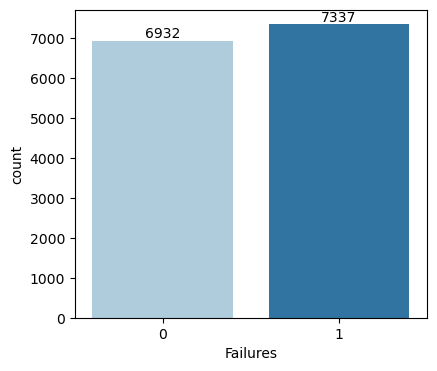

In [11]:
plt.figure(figsize=(10,4))
for idx, feature in enumerate(target1):
  plt.subplot(1,2,idx+1)
  f = sns.countplot(data = df_resampled_1, x = feature, palette="Paired")
  f.bar_label(f.containers[0])

In [14]:
df_resampled_1.to_csv('Failures_Boosted.csv')

TWF BOOSTING

In [15]:
class Boosting_TWF:
    def __init__(self, df):
        self.df = df
        self.df2 = None  # Initialize df2 attribute

    def process_data(self):
        self.df2 = self.df.drop(['Failures'], axis=1)
        for i in (('L', 0), ('M', 1), ('H', 2)):
            self.df2['Type'] = self.df2['Type'].replace(*i)

    def resample_data(self):
        X = self.df2.drop(['TWF'], axis=1).values
        y_twf = self.df2['TWF'].values

        X_train, X_test, y_train, y_test = train_test_split(X, y_twf, test_size=0.2, random_state=42)

        smote_enn = SMOTEENN(sampling_strategy='auto', random_state=42)

        X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)

        df_resampled_2 = pd.DataFrame(X_train_resampled, columns=self.df2.drop(['TWF'], axis=1).columns)
        df_resampled_2['TWF'] = y_train_resampled

        return df_resampled_2
    
Boosting_TWF = Boosting_TWF(df)
Boosting_TWF.process_data()
df_resampled_2 = Boosting_TWF.resample_data()

In [16]:
df_resampled_2

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Temp_Delta,Power,Time/Part,Planned_Stop,TWF
0,0.000000,298.200000,308.400000,1388.000000,53.800000,137.000000,10.200000,7819.884882,2.000000,0.0,0
1,1.000000,300.900000,310.800000,1599.000000,33.000000,7.000000,9.900000,5525.747318,3.000000,0.0,0
2,0.000000,301.400000,310.500000,1571.000000,33.900000,208.000000,9.100000,5577.049526,2.000000,0.0,0
3,0.000000,300.500000,310.500000,1373.000000,47.400000,56.000000,10.000000,6815.182607,2.000000,0.0,0
4,1.000000,297.300000,308.800000,1469.000000,44.100000,150.000000,11.500000,6784.049424,3.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
15150,0.000000,299.019532,309.274496,1463.910412,40.990073,208.774818,10.254964,6281.841826,2.000000,0.0,1
15151,1.892004,298.132191,307.610591,1600.004162,36.164797,224.028039,9.478401,6059.010705,4.838007,0.0,1
15152,0.000000,299.311904,310.440713,2022.545594,21.254517,208.745251,11.128810,4448.497236,2.000000,0.0,1
15153,1.000000,300.296664,311.696664,1588.909136,32.040810,210.808374,11.400000,5319.841297,3.000000,0.0,1


In [17]:
df_resampled_2['TWF'].sum()

7764

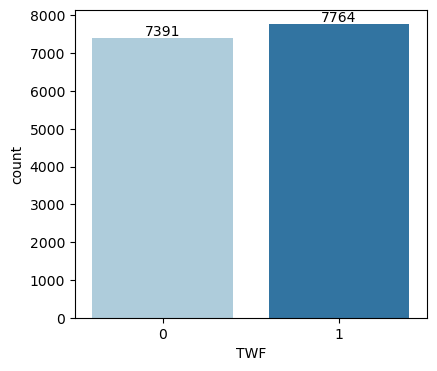

In [18]:
plt.figure(figsize=(10,4))
for idx, feature in enumerate(target2):
  plt.subplot(1,2,idx+1)
  f = sns.countplot(data = df_resampled_2, x = feature, palette="Paired")
  f.bar_label(f.containers[0])

In [15]:
df_resampled_2.to_csv('TWF_Boosted.csv')

In [16]:
df_boosted = pd.concat([df_resampled_2,df_resampled_1])

In [17]:
df_boosted.describe()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Temp_Delta,Power,Time/Part,TWF,Failures
count,29424.000000,29424.000000,29424.000000,29424.000000,29424.000000,29424.000000,29424.000000,29424.000000,29424.000000,15155.000000,14269.000000
mean,0.468598,300.339149,310.150744,1545.137311,41.606246,140.210137,9.811596,6426.360737,2.555295,0.512306,0.514192
std,0.600098,1.855264,1.313170,264.304573,12.982057,72.229249,1.027660,1406.876604,0.809157,0.499865,0.499816
min,0.000000,295.300000,305.700000,1181.000000,3.800000,0.000000,7.600000,1148.440610,2.000000,0.000000,0.000000
25%,0.000000,298.900000,309.200000,1381.606845,33.100000,76.137178,9.100000,5519.253271,2.000000,0.000000,0.000000
50%,0.000000,300.400000,310.300000,1475.000000,41.400000,153.000000,9.700000,6321.009750,2.000000,1.000000,1.000000
75%,1.000000,301.900000,311.055687,1606.000000,49.982672,208.550659,10.786325,7274.882768,3.000000,1.000000,1.000000
max,2.000000,304.500000,313.800000,2886.000000,76.200000,253.000000,12.100000,10233.151638,5.000000,1.000000,1.000000


In [18]:
df_boosted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29424 entries, 0 to 14268
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Type                     29424 non-null  float64
 1   Air temperature [K]      29424 non-null  float64
 2   Process temperature [K]  29424 non-null  float64
 3   Rotational speed [rpm]   29424 non-null  float64
 4   Torque [Nm]              29424 non-null  float64
 5   Tool wear [min]          29424 non-null  float64
 6   Temp_Delta               29424 non-null  float64
 7   Power                    29424 non-null  float64
 8   Time/Part                29424 non-null  float64
 9   TWF                      15155 non-null  float64
 10  Failures                 14269 non-null  float64
dtypes: float64(11)
memory usage: 2.7 MB


In [19]:
df_boosted.to_csv('df_Boosted.csv')